In [1]:
import tensorflow as tf
import keras 
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from keras.utils import img_to_array

In [2]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 128
_img = []
path = '/Users/arpitpatel/Documents/BTP/model/IITD Palmprint V1/Segmented/Left'
files = os.listdir(path)
files = sorted_alphanumeric(files)
counter =0
for i in tqdm(files):    
#         if i == '230_5.bmp':
        if i == '219_5.bmp':
#         if counter ==1300:
            break
        else:    
            img = cv2.imread(path + '/'+i,-1)
#             print(img.shape) 
            rgb_batch = np.repeat(img[..., np.newaxis], 3, -1)
#             print(rgb_batch.shape)  # (64, 224, 224, 3)
            # open cv reads images in BGR format so we have to convert it to RGB
#             rgb_batch = np.repeat(grayscale_batch[..., np.newaxis], 3, -1)
            
            img = cv2.cvtColor(rgb_batch, cv2.COLOR_BGR2RGB)
            #resizing image
#             print(img.shape)
            img = cv2.resize(img, (SIZE, SIZE))
#             print(img.shape)
            img = (img - 127.5) / 127.5
#             print(img.shape)
            imh = img.astype(float)
#             print(imh.shape)
            _img.append(img_to_array(img))
#             counter=counter+1
#             print(_img)

 95%|███████████████████████████████████  | 1234/1302 [00:00<00:00, 2145.06it/s]


In [ ]:
def plot_images(sqr = 5):
    plt.figure(figsize = (10,10))
    plt.title("Real Images",fontsize = 35)
    for i in range(sqr * sqr):
        plt.subplot(sqr,sqr,i+1)
        plt.imshow(_img[i]*0.5 + 0.5 )
        plt.xticks([])
        plt.yticks([])

# to plot images
plot_images(6)
plt.show()


/var/folders/h6/xx1t5kw94kb_50dv5ff81b6r0000gn/T/ipykernel_46374/4045412341.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(sqr,sqr,i+1)


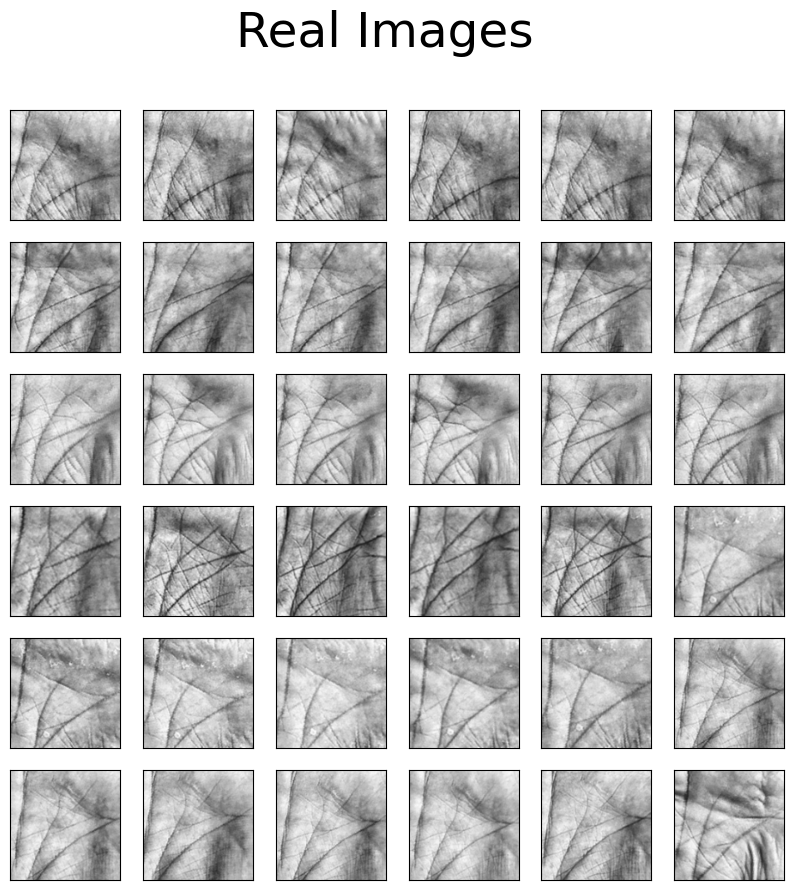

In [4]:
def plot_images(sqr=5):
    fig, axs = plt.subplots(sqr, sqr, figsize=(10, 10))
    fig.suptitle("Real Images", fontsize=35)

    for i, ax in enumerate(axs.flat):
        ax.imshow(_img[i] * 0.5 + 0.5)
        ax.set_xticks([])
        ax.set_yticks([])
plot_images(6)

In [5]:
batch_size = 32
dataset=tf.data.Dataset.from_tensor_slices(np.array(_img)).batch(batch_size)

Metal device set to: Apple M1


2023-09-13 19:07:22.402661: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-13 19:07:22.402686: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
latent_dim = 100
def Generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128*128*3, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.Reshape((128,128,3)))
    # downsampling
    model.add(tf.keras.layers.Conv2D(128,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    
    model.add(tf.keras.layers.LeakyReLU())
    #upsampling
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(3,4,strides = 1, padding = 'same',activation = 'tanh'))
    
    

    return model

In [7]:
generator = Generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 49152)             4915200   
                                                                 
 reshape (Reshape)           (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 128)     6144      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       262144    
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 128)       0         
                                                        

In [8]:
def Discriminator():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input((SIZE, SIZE, 3)))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))
    return model
  

In [9]:
discriminator = Discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       6144      
                                                                 
 batch_normalization_5 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 128)       262144    
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 128)      

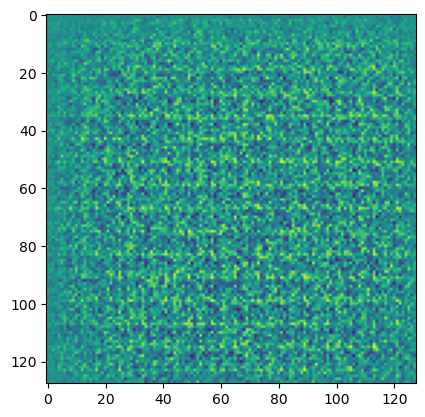

In [10]:
noise = np.random.normal(-1,1,(1,100))
img = generator(noise)
plt.imshow(img[0,:,:,0])
plt.show()

In [11]:
optimizer = tf.keras.optimizers.legacy.RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )
# cross_entropy = tf.keras.losses.MeanSquaredError()

/Users/arpitpatel/tensorflow-test/env/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:


# Generator and Discriminator models go here...

# Generator and Discriminator optimizers
# optimizer = tf.keras.optimizers.RMSprop(
#     lr=0.0001  # You can adjust the learning rate as needed
# )

# discriminator_optimizer = tf.keras.optimizers.RMSprop(
#     lr=0.0001  # You can adjust the learning rate as needed
# )

# LSGAN loss function
def generator_loss(fake_output):
    return tf.reduce_mean(tf.square(fake_output - 1))

def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(tf.square(real_output - 1))
    fake_loss = tf.reduce_mean(tf.square(fake_output))
    return real_loss + fake_loss

# Create instances of the loss functions
generator_loss_fn = generator_loss
discriminator_loss_fn = discriminator_loss


In [13]:
# def generator_loss(fake_output):
#     return cross_entropy(tf.ones_like(fake_output),fake_output)
# def discriminator_loss(fake_output, real_output):
#     fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
#     real_loss = cross_entropy(tf.ones_like(real_output),real_output)
#     return fake_loss + real_loss

In [14]:
def train_steps(images):
    noise = np.random.normal(0,1,(batch_size,latent_dim))
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        generated_images = generator(noise)
        fake_output = discriminator(generated_images)
        real_output = discriminator(images)
        
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)
        
        
    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)    
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)
    
    optimizer.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))
    
    loss = {'gen loss':gen_loss,
           'disc loss': dis_loss}
    return loss

In [15]:
def plot_generated_images(square = 5, epochs = 0):
    
    
  plt.figure(figsize = (10,10))
  for i in range(square * square):
    if epochs != 0:    
        if(i == square //2):
            plt.title("Generated Image at Epoch:{}\n".format(epochs), fontsize = 32, color = 'black')
    plt.subplot(square, square, i+1)
    noise = np.random.normal(0,1,(1,latent_dim))
    img = generator(noise)
    plt.imshow(np.clip((img[0,...]+1)/2, 0, 1))
    
    plt.xticks([])
    plt.yticks([])
    plt.grid()

In [16]:
import time
def train(epochs,dataset):
    
    for epoch in range(epochs):
        start = time.time()
        print("\nEpoch : {}".format(epoch + 1))
        for images in dataset:
            loss = train_steps(images)
        print(" Time:{}".format(np.round(time.time() - start),2)) 
        print("Generator Loss: {} Discriminator Loss: {}".format(loss['gen loss'],loss['disc loss']))

In [17]:
train(5,dataset)
# i had train model previously for more than 10 epochs so generated images are quiet good


Epoch : 1
 Time:286.0
Generator Loss: 4.1003215045520847e-08 Discriminator Loss: 4.1162863340105105e-08

Epoch : 2
 Time:286.0
Generator Loss: 1.5963015798092783e-08 Discriminator Loss: 1.6021601823013043e-08

Epoch : 3
 Time:287.0
Generator Loss: 4.534087771901341e-09 Discriminator Loss: 4.541500953081368e-09

Epoch : 4
 Time:282.0
Generator Loss: 1.0655560878092274e-09 Discriminator Loss: 1.0663031568824977e-09

Epoch : 5
 Time:284.0
Generator Loss: 3.8920378031548353e-10 Discriminator Loss: 3.892965949603422e-10


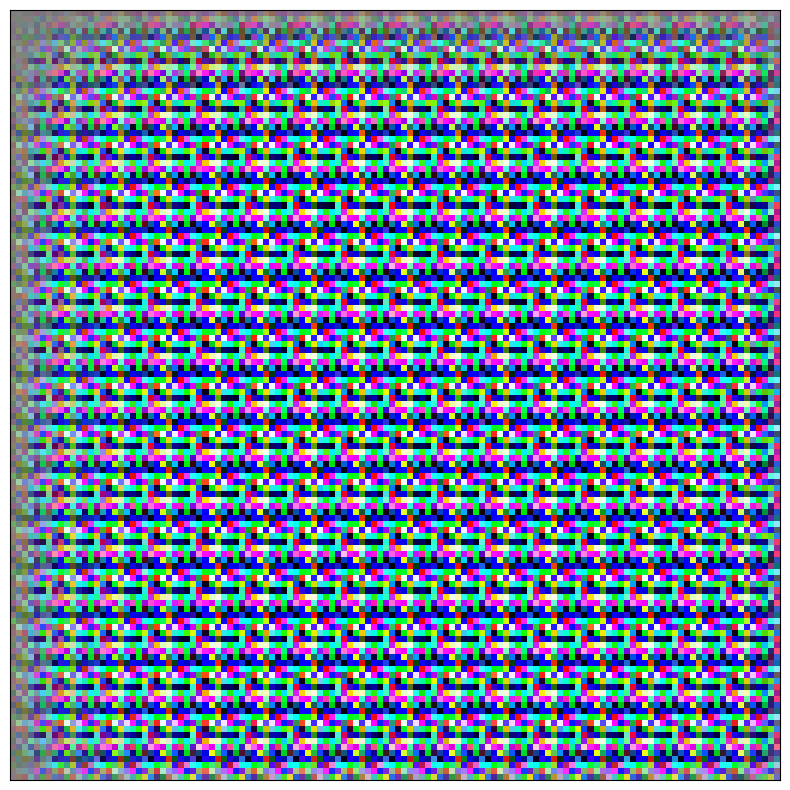

In [18]:
plot_generated_images(1)

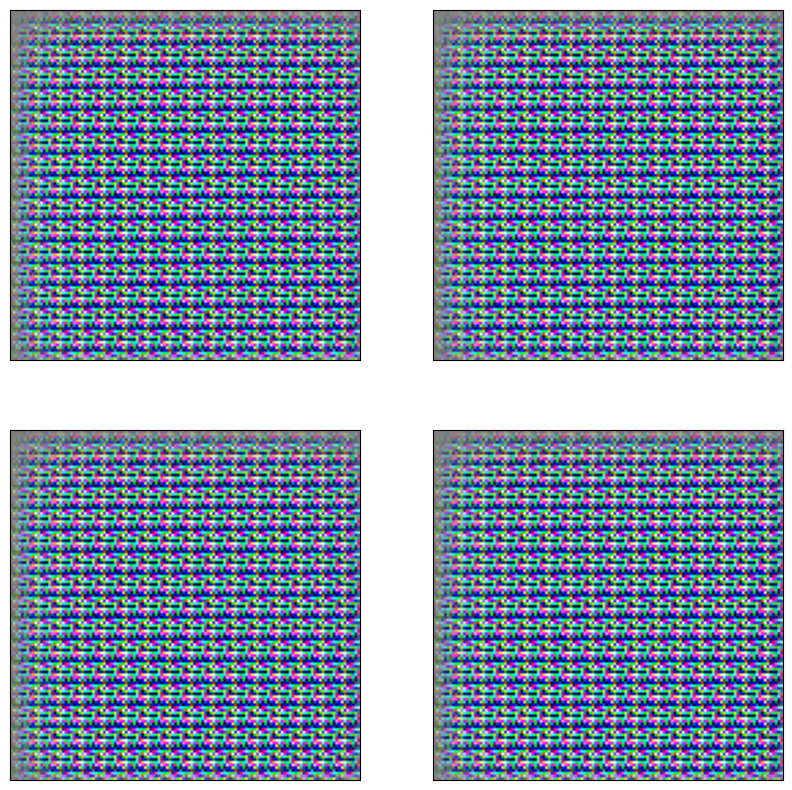

In [19]:
plot_generated_images(2)


In [ ]:
plot_generated_images(500)


In [ ]:
generator.save('generator.h5')
discriminator.save("discriminator.h5")